In [1]:
%load_ext autoreload
%autoreload 2

### Carla tracks explorative data analysis

Main task of this notebook is to get a sense for the carla data.

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial import distance
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, LineString
import pandas as pd
#from src.generate_traffic_data import clean_carla, spawn_scene, run_scene
import carla
import os
os.getcwd()
from datetime import datetime
import time
import random
from tqdm import tqdm

#client = carla.Client('localhost', 2000)
#client.set_timeout(10.0)
#world = client.get_world()

os.chdir('../..')
os.getcwd()

'/home/tmuehlen/repos/graph_coverage'

In [3]:
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.get_world()

In [4]:
from graph_creator.MapGraph import MapGraph

In [5]:
world_map = world.get_map()

In [16]:
give_it_a_try = MapGraph()

In [19]:
g = give_it_a_try.create_from_carla_map(world_map)

In [13]:
#give_it_a_try.visualize_graph()


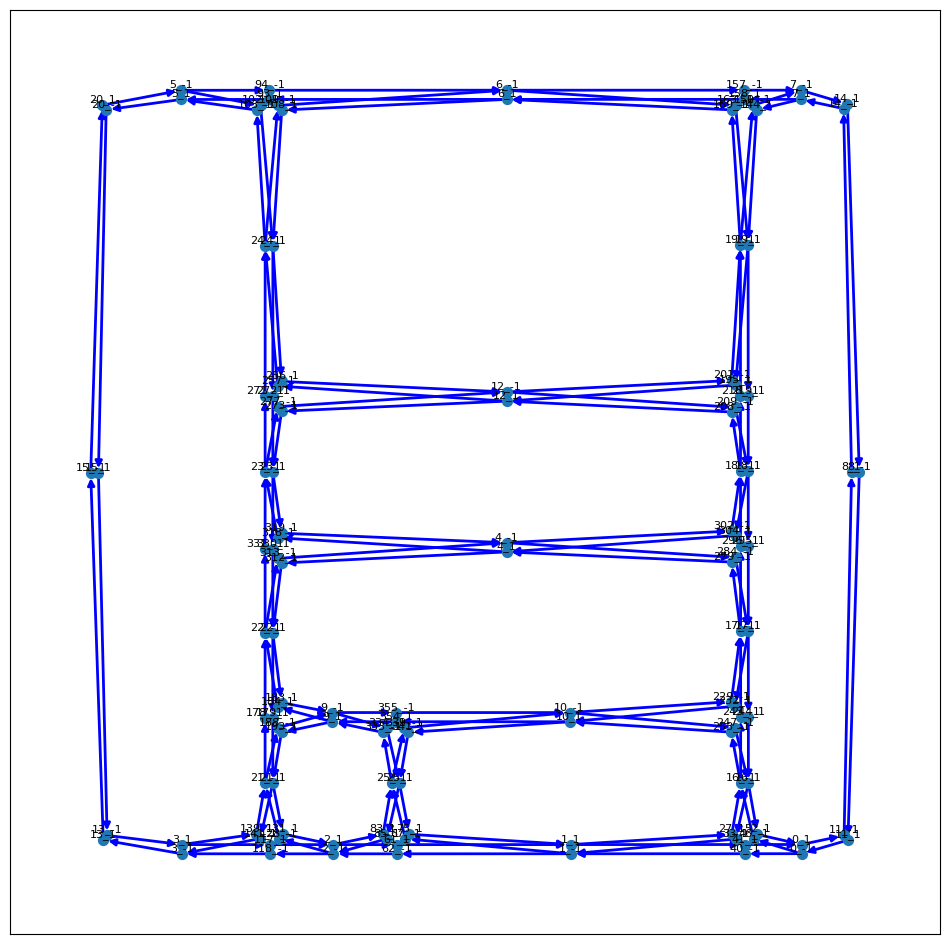

In [ ]:
g.visualize_graph()

In [ ]:
track_files = os.listdir(Path('carla/data') )
dfs = []
for file in track_files:
    df = pd.read_parquet(Path('carla/data') / file)
    df['file_name'] = file
    dfs.append(df)

tracks_df = pd.concat(dfs)

tracks_df['actor_location_x'] = tracks_df.actor_location_xyz.apply(lambda x: x[0])
tracks_df['actor_location_y'] = tracks_df.actor_location_xyz.apply(lambda x: x[1])
tracks_df['actor_location_z'] = tracks_df.actor_location_xyz.apply(lambda x: x[2])

print(tracks_df.shape)
tracks_df.head(2)


In [ ]:
sns.histplot(data = tracks_df, x = 'actor_speed', bins=100, hue = 'file_name')
plt.show()
sns.histplot(data = tracks_df, x = 'actor_acceleration', bins=100, hue = 'file_name')
plt.show()
tracks_df.groupby(['map', 'file_name']).size()


### High level learnings:

* hm, timestamps are not alligned, getting syncronous mode running would be great...
* road_id and lane_id seem to be ok


In [ ]:
# tracks_df.timestamp.value_counts()
# tracks_df.road_id.value_counts()
# tracks_df.actor_id.value_counts()

In [ ]:
# pick a timestamp and filename and calculate distances:

In [ ]:
i = 100

mask = (tracks_df.timestamp == tracks_df.timestamp.iloc[i]) &  (tracks_df.file_name == tracks_df.file_name.iloc[i])
mask.sum()
actor_id = tracks_df.actor_id.iloc[i]

plt.scatter(tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_y, label = 'OMV')
plt.scatter(tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_y, label = 'ego')
plt.show()
tracks_df[mask][['actor_location_x', 'actor_location_y']]

In [ ]:
# define 1 actor as the ego:
# distance.pdist(tracks_df[mask][['actor_location_x', 'actor_location_y']])
# tracks_df[mask][['actor_location_x', 'actor_location_y']]

In [ ]:
# dist_threshold = 150
# distance.cdist(tracks_df[mask & (tracks_df.actor_id == actor_id)][['actor_location_x', 'actor_location_y']], tracks_df[mask][['actor_location_x', 'actor_location_y']])


In [ ]:
#tracks_df.actor_id

#tracks_df[mask & (tracks_df.actor_id == actor_id) ][['actor_location_x', 'actor_location_y']]

In [ ]:
# print(actor_id)
#tracks_df[mask]


In [ ]:
#tracks_df[mask]['map'].iloc[0]

#client.load_world('/Game/' + tracks_df[mask]['map'].iloc[0])
#world_map = world.get_map()
#xodr_map = world_map.to_opendrive()

#with open("carla_map.xodr", "w") as file:
#    file.write(xodr_map)

### map data preparation

In [ ]:

#ET.fromstring('carla_map.xodr')
tree = ET.parse('carla_map.xodr')
root = tree.getroot()


In [ ]:
#type(tmp)
#print(tmp)

# Load the OpenDRIVE XML
#tree = ET.ElementTree(ET.fromstring('carla_map.xodr'))

# OpenDRIVE namespace
#namespace = {'xodr': 'http://www.opendrive.org'}

# Find all roads
#roads = root.findall("road")
#print(f"Total Roads Found: {len(roads)}")


In [ ]:
junctions = root.findall('junction')
print(len(junctions))

roads = root.findall('road')
print(len(roads))
#i = 10
#roads[i].get('id')
#print(roads[i].get('length'), roads[i].get('junction')) # no junction is -1


In [ ]:
# roads[i].find('link').find('successor').get('elementId')
# roads[i].find('link').find('predecessor').get('elementId')

In [ ]:
all_lanes = []
# all_lanes is a list, containing all individual lanes, with their right/left neighbor (max 1), their type, 
# length, width, and predecessor and successor


In [ ]:
# start buiding the lane map:
# non-junctions:
#tracks_df[mask]
road = roads[0]
road.get('id')
lanes = road.find('lanes')
left_lanes = lanes.find('laneSection').find('left')
right_lanes = lanes.find('laneSection').find('right')
links = road.find('link')
predecessor = links.find('predecessor')
successor = links.find('successor')

In [ ]:
left_lanes[0].get('id')
lane = left_lanes[0]
lane.get('type')
float(road.get('length'))
left_lanes

In [ ]:
road.get('junction')


In [ ]:
# https://carla.org/Doxygen/html/df/d85/classcarla_1_1road_1_1Lane.html#a0a674e01dcb347b12407a26b94521685

In [ ]:
# process left lanes of road's:
left_lane_ids = [int(lane.get('id')) for lane in left_lanes]
print(left_lane_ids)
# left neighbors for right lanes
left_neighbor = left_lane_ids[1:]
left_neighbor = left_neighbor + [-1] # todo, need to check, if this lane actually exists.
print(left_neighbor)
# right neighbors for right lanes:
right_neighbor = left_lane_ids[:-1]
right_neighbor = [None] + right_neighbor
print(right_neighbor)

In [ ]:
i = 1
#for i in range(len(left_lanes)):
lane_dict = {} 
lane_dict['lane_road_id'] = road.get('id') + '_' + left_lanes[i].get('id')
lane_dict['type'] = left_lanes[i].get('type')
lane_dict['length'] = float(road.get('length'))
if left_neighbor[i]:
    lane_dict['left_neighbor'] = road.get('id') + '_' + str(left_neighbor[i])

if right_neighbor[i]:
    lane_dict['right_neighbor'] = road.get('id') + '_' + str(right_neighbor[i])

lane_dict['lane_direction'] = 'left'
#all_lanes.append(lane_dict)

lane_dict['lane_id'] = left_lanes[i].get('id')
lane_dict['road_id'] = road.get('id')

road.get('junction')

In [ ]:
left_lanes[i]

In [ ]:
lane_dict

In [ ]:
if road.get('junction') == '-1':
    if predecessor.get('elementType') == 'junction':
        print('test')


In [ ]:
predecessor.get('elementId')

In [ ]:
# get the predecessor junction:
pred_junction = [j for j in junctions if j.get('id') == predecessor.get('elementId')][0]
all_pred_connections = pred_junction.findall('connection')
all_pred_connections
#pred_junction.get('id')

In [ ]:
connections = [conn for conn in all_pred_connections if conn.get('incomingRoad') == road.get('id')]
connections

In [ ]:

#for i in range(4):
i = 0
lane_links = connections[i].findall('laneLink')
print(len(lane_links))
print(connections[i].get('incomingRoad'), connections[i].get('connectingRoad'), lane_links[0].get('from'), lane_links[0].get('to'))

#print(connections[0].get('incomingRoad'), connections[0].get('connectingRoad'), lane_links[0].get('from'), lane_links[0].get('to'))
#print(connections[0].get('incomingRoad'), connections[0].get('connectingRoad'), lane_links[0].get('from'), lane_links[0].get('to'))
#print(connections[0].get('incomingRoad'), connections[0].get('connectingRoad'), lane_links[0].get('from'), lane_links[0].get('to'))


In [ ]:
predecessor_list = []
for lane_link in lane_links:
    if (lane_link.get('to') == lane_dict['lane_id']) & (connections[i].get('incomingRoad') == lane_dict['road_id']):
        print(lane_dict['lane_id'], 
              lane_dict['road_id'], 
              lane_link.get('to'), 
              lane_link.get('from'),
              connections[i].get('incomingRoad'), 
              connections[i].get('connectingRoad'))
        predecessor_list.append()


In [ ]:
lane_dict

In [ ]:
lane_links[0].get('to')

In [ ]:
lane_dict

In [ ]:
#

In [ ]:
all_lanes
lane_dict

In [ ]:
# process right lanes of roads:

In [ ]:
right_lane_ids = [int(lane.get('id')) for lane in right_lanes]
print(right_lane_ids)
# left neighbors for right lanes
left_neighbor = right_lane_ids[:-1]
left_neighbor = [1] + left_neighbor # todo: check if this actually exists
print(left_neighbor)
# right neighbors for right lanes:
right_neighbor = right_lane_ids[1:]
right_neighbor = right_neighbor + [None]
print(right_neighbor)


In [ ]:
for i in range(len(right_lanes)):
    lane_dict = {} 
    lane_dict['lane_id'] = road.get('id') + '_' + right_lanes[i].get('id')
    lane_dict['type'] = right_lanes[i].get('type')
    lane_dict['length'] = float(road.get('length'))
    if left_neighbor[i]:
        lane_dict['left_neighbor'] = road.get('id') + '_' + str(left_neighbor[i])

    if right_neighbor[i]:
        lane_dict['right_neighbor'] = road.get('id') + '_' + str(right_neighbor[i])
    lane_dict['lane_direction'] = 'right'
    all_lanes.append(lane_dict)


In [ ]:
all_lanes

### Continue from here

* Fill up the lane dict with left/right neighbor
* Fill up lane dict with predessecor/successor
    * split by if next road is a junction or not.
* Fill it into Marius' road network class

In [ ]:
print(ET.tostring(roads[i], encoding = 'utf-8').decode('utf-8'))


In [ ]:
# Extract road connections
road_connections = {}

for road in roads:
    road_id = road.get("id")
    
    link = road.find("link")
    if link is not None:
        successor = link.find("successor")
        predecessor = link.find("predecessor")

        successor_id = successor.get("elementId") if successor is not None else None
        predecessor_id = predecessor.get("elementId") if predecessor is not None else None

        road_connections[road_id] = {
            "successor": successor_id,
            "predecessor": predecessor_id
        }

# Print road connections
for road_id, links in road_connections.items():
    print(f"Road ID: {road_id} -> Successor: {links['successor']}, Predecessor: {links['predecessor']}")


In [ ]:
carla_map = world.get_map()
waypoints = carla_map.generate_waypoints(0.50)

# Store road polygons
road_polygons = []

# Process each waypoint to extract boundaries
for waypoint in waypoints:
    # Get left and right lane markings
    left_marking = waypoint.get_left_lane()
    right_marking = waypoint.get_right_lane()

    if left_marking and right_marking:
        # Extract boundary points
        left_x, left_y = left_marking.transform.location.x, left_marking.transform.location.y
        right_x, right_y = right_marking.transform.location.x, right_marking.transform.location.y

        # Create polygon for road segment
        road_polygon = Polygon([
            (waypoint.transform.location.x, waypoint.transform.location.y),  # Center
            (left_x, left_y),  # Left boundary
            (right_x, right_y)  # Right boundary
        ])

        road_polygons.append(road_polygon)

print(f"Total road polygons created: {len(road_polygons)}")

In [ ]:
# Plot the road polygons
plt.figure(figsize=(10, 8))

for polygon in road_polygons:
    x, y = polygon.exterior.xy  # Get polygon boundary
    plt.fill(x, y, alpha=0.5, edgecolor="black")

plt.scatter(tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_y, label = 'OMV')
plt.scatter(tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_y, label = 'ego')

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("CARLA Road Boundaries with Shapely Polygons")
plt.grid(True)
plt.show()

### Finally, start building the graph

In [ ]:
tracks_df.file_name.unique()

In [ ]:

file_name = tracks_df.file_name.unique()[3]
mask_file_name = tracks_df.file_name == file_name
mask_time = ((tracks_df.timestamp - tracks_df[mask_file_name].timestamp.mean()).abs() <= 3) # i.e. 10 seconds

tracks_subset = tracks_df[mask_file_name & mask_time]

actors = tracks_subset.actor_id.unique().tolist()
ego_idx = 0
ls_list = []
for actor in actors:
    mask_actor = (tracks_subset.actor_id == actor)
    ls_list.append(LineString(tracks_subset[mask_actor][['actor_location_x', 'actor_location_y']].values.tolist()))

#mask_actor = (tracks_subset.actor_id == actors[1])
#ls1 = LineString(tracks_subset[mask_actor][['actor_location_x', 'actor_location_y']].values.tolist())

#[ls.crosses(ls_list[ego_idx]) for ls in ls_list]


In [ ]:
# include all actors with a crossing path and inside a circle:

In [ ]:
[ls.distance(ls_list[ego_idx]) for ls in ls_list]

In [ ]:
[ls.distance(ls_list[ego_idx]) < 80 for ls in ls_list]
actor_idx = [i for i in range(len(ls_list)) if ls_list[i].distance(ls_list[ego_idx]) < 80 ]


In [ ]:
actors_in_graph = [actors[i] for i in actor_idx]


In [ ]:
timestamp = tracks_subset.timestamp.unique()[60]

In [ ]:
# First very simple rule: distance between actors < 40 m

mask = tracks_subset.actor_id.isin(actors_in_graph) & (tracks_subset.timestamp == timestamp)
tracks_subset[mask]